# <font color='red'> Movies Recommender System

# <font color='green'> 1. Business Problem

## 1.1 Problem Statement

__Given the movie metadata and user ratings on different movies, we have to recommend new movies to the user.__

## 1.2 Data Overview

Source: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

<pre>

Of all the 26 million ratings from 270,000 users for all 45,000 movies available, we consider a subset of 100,000 ratings on 9000 movies rated by 700 users (ratings_small.csv)*

We also don't need the credits.csv file which contains the cast and crew information of all the movies.*

</pre>
So, the files we will use here are:

* <b>movies_metadata.csv</b> : <p>The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.</p>

* <b>keywords.csv</b> : <p>Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.</p>

* <b>links_small.csv</b> : <p>Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.</p>

* <b>ratings_small.csv</b> : <p>The subset of 100,000 ratings from 700 users on 9,000 movies.</p>

## 1.3 Sources/Useful Links

* https://www.infoworld.com/article/3241852/how-to-implement-a-recommender-system.html
* https://medium.com/pinterest-engineering/introducing-pixie-an-advanced-graph-based-recommendation-system-e7b4229b664b
* https://surpriselib.com/
* https://surprise.readthedocs.io/en/stable/matrix_factorization.html

## 1.4 Business Objectives and Constraints

* Objectives
<pre>
    * Based on the user's ratings on other movies, predict their rating on a movie which they have not yet rated. 
    * Minimize the difference between true and predicted ratings.
    * Suggest movies similar to a movie based on it's genre and plot keywords. 
</pre>
* Constraints
<pre>
    * Interpretability
    * No strict low latency requirements
</pre>

## 1.5 Type of machine learning problem

This is a recommender systems problem since we have to recommend new movies given the ratings on other movies.

It can also be thought of as a Regression problem.

## 1.6 Performance metric

Mean Squared Error(MSE) or Root Mean squared Error(RMSE)

### <font color='blue'>Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import ast 
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error
from surprise import Reader,Dataset
from surprise import BaselineOnly, SVD, SVDpp
import surprise
import pickle
from prettytable import PrettyTable
from tqdm import tqdm
import networkx as nx
from networkx.algorithms import bipartite
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')
path_ = 'C:/Users/ANKUR/Desktop/Project/'

# <font color='green'> 2. Exploratory Data Analysis

##  2.1 Loading the data

In [2]:
#https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
movies = pd.read_csv(path_+'movies_metadata.csv')
ratings = pd.read_csv(path_+'ratings_small.csv')
keywords = pd.read_csv(path_+'keywords.csv')
links = pd.read_csv(path_+'links_small.csv')

In [3]:
print('movies   :', movies.shape)
print('ratings  :', ratings.shape)
print('keywords :', keywords.shape)
print('links    :', links.shape)

movies   : (45466, 24)
ratings  : (100004, 4)
keywords : (46419, 2)
links    : (9125, 3)


## 2.2 Data Cleaning

### Removing duplicate rows

In [4]:
print('No. of duplicate rows in movies:', movies.duplicated().sum())
movies.drop_duplicates(inplace=True)

No. of duplicate rows in movies: 13


In [5]:
print('No. of duplicate rows in keywords:', keywords.duplicated().sum())
keywords.drop_duplicates(inplace=True)

No. of duplicate rows in keywords: 987


### Removing NaN rows

In [6]:
#movies[movies.title.isnull()]
print('No. of rows where title is NaN:', movies.title.isnull().sum())
movies.drop(movies[movies.title.isnull()].index, inplace=True)

No. of rows where title is NaN: 6


### Merging the dataframes

In [7]:
movies.columns #we don't need all the columns... during prediction, we use tmdb api for getting poster_path and other details

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [8]:
movies = movies[['id','title','genres']]
movies.shape

(45447, 3)

In [9]:
movies.id = movies.id.astype(float)                                 #object --> float
movies = movies.merge(links, left_on='id', right_on='tmdbId')
movies.drop(['imdbId','id'], axis=1, inplace=True)               #tmdbId is required for fetching details during prediction
display(movies.head())
print(movies.shape)

,title,genres,movieId,tmdbId
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,862.0
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2,8844.0
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",3,15602.0
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",4,31357.0
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",5,11862.0


(9092, 4)


In [10]:
print('No. of duplicate rows:', movies.duplicated().sum())
movies.drop_duplicates(inplace=True)
movies.shape

No. of duplicate rows: 10


(9082, 4)

In [11]:
movies = movies.merge(keywords, left_on='tmdbId', right_on='id')
movies.drop(['id'], axis=1, inplace=True)
movies.head()

,title,genres,movieId,tmdbId,keywords
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,862.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",2,8844.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",3,15602.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",4,31357.0,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",5,11862.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [12]:
def cleans(row):
    if len(row)>0:
        return str([(i['name'].lower().strip()) for i in row])
    return str(row)
            
#genres and keywords coulumn are of type str and json format.. we get the genre names in a list and store it in str format again
movies.keywords = movies.keywords.apply(lambda x: cleans(ast.literal_eval(x)))
movies.genres = movies.genres.apply(lambda x: cleans(ast.literal_eval(x)))  

In [13]:
if not os.path.isfile(path_+'movie_ratings.csv'):
    movie_ratings = movies.merge(ratings, on='movieId')
    movie_ratings.sort_values('timestamp', inplace=True)
    movie_ratings.to_csv(path_+'movie_ratings.csv', index=False)
movie_ratings = pd.read_csv(path_+'movie_ratings.csv')
print(movie_ratings.shape)
movie_ratings.head()

(99810, 8)


,title,genres,movieId,tmdbId,keywords,userId,rating,timestamp
0,Se7en,"['crime', 'mystery', 'thriller']",47,807.0,"['self-fulfilling prophecy', 'detective', 's.w...",383,5.0,789652009
1,A Fish Called Wanda,"['comedy', 'crime']",1079,623.0,"['robbery', 'infidelity', 'cheating', 'heart a...",383,3.0,789652009
2,Get Shorty,"['comedy', 'thriller', 'crime']",21,8012.0,"['gambling', 'miami', 'based on novel', 'job',...",383,3.0,789652009
3,Shanghai Triad,"['drama', 'crime']",30,37557.0,"['servant', 'cabaret', 'shanghai', 'diva', 'un...",409,5.0,828212412
4,Carrington,"['history', 'drama', 'romance']",35,47018.0,"['england', 'painter', 'conscientious objector...",409,4.0,828212412


## 2.3 Basic Statistics Ratings 

In [14]:
ratings.sort_values('timestamp', inplace=True)
ratings.rating.describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## 2.4 Train Test Temporal Split

In [15]:
#X_train, X_test = train_test_split(movie_ratings, test_size=0.05, shuffle=False)
if not (os.path.isfile(path_+'xtrain.csv') and os.path.isfile(path_+'xtest.csv')): 
    movie_ratings[:int(len(movie_ratings)*0.8)].to_csv(path_+'xtrain.csv', index=False)
    movie_ratings[int(len(movie_ratings)*0.8):].to_csv(path_+'xtest.csv', index=False)

X_train = pd.read_csv(path_+'xtrain.csv')
X_test = pd.read_csv(path_+'xtest.csv')
print(X_train.shape)
print(X_test.shape)

(79848, 8)
(19962, 8)


## 2.5 Cold Start Problem

In [16]:
train_movies = set(X_train.movieId.values)
test_movies = set(X_test.movieId.values)
total_movies = train_movies.union(test_movies)
print('No. of movies in train set:', len(train_movies))
print('No. of movies in test set:', len(test_movies))
print('No. of movies common in train and test sets:', len(train_movies.intersection(test_movies)))
print('No. of movies present in train set but not in test set:', len(train_movies-test_movies))
print('No. of movies present in test set but not in train set:', len(test_movies-train_movies))
print('Percentage of movies present in test but not in train set of all the movies: {}%'.format(len(test_movies-train_movies)/len(total_movies)*100))

No. of movies in train set: 7328
No. of movies in test set: 4732
No. of movies common in train and test sets: 3035
No. of movies present in train set but not in test set: 4293
No. of movies present in test set but not in train set: 1697
Percentage of movies present in test but not in train set of all the movies: 18.803324099722992%


In [17]:
train_users = set(X_train.userId.values)
test_users = set(X_test.userId.values)
total_users = train_users.union(test_users)
print('No. of users in train set:', len(train_users))
print('No. of users in test set:', len(test_users))
print('No. of users common in train and test sets:', len(train_users.intersection(test_users)))
print('No. of users present in train set but not in test set:', len(train_users-test_users))
print('No. of users present in test set but not in train set:', len(test_users-train_users))
print('Percentage of users present in test but not in train set of all the users: {}%'.format(len(test_users-train_users)/len(total_users)*100))

No. of users in train set: 546
No. of users in test set: 148
No. of users common in train and test sets: 23
No. of users present in train set but not in test set: 523
No. of users present in test set but not in train set: 125
Percentage of users present in test but not in train set of all the users: 18.628912071535023%


> Roughly same percentage of movies and users are new in the test dataset

In [18]:
if not (os.path.isfile(path_+'train_movies.csv') and os.path.isfile(path_+'test_movies.csv')):
    movies[movies.movieId.isin(train_movies)].to_csv(path_+'train_movies.csv',index=False)
    movies[movies.movieId.isin(test_movies)].to_csv(path_+'test_movies.csv',index=False)

In [19]:
train_movies = pd.read_csv(path_+'train_movies.csv')
train_movies.head()

,title,genres,movieId,tmdbId,keywords
0,Toy Story,"['animation', 'comedy', 'family']",1,862.0,"['jealousy', 'toy', 'boy', 'friendship', 'frie..."
1,Jumanji,"['adventure', 'fantasy', 'family']",2,8844.0,"['board game', 'disappearance', ""based on chil..."
2,Grumpier Old Men,"['romance', 'comedy']",3,15602.0,"['fishing', 'best friend', 'duringcreditssting..."
3,Waiting to Exhale,"['comedy', 'drama', 'romance']",4,31357.0,"['based on novel', 'interracial relationship',..."
4,Father of the Bride Part II,['comedy'],5,11862.0,"['baby', 'midlife crisis', 'confidence', 'agin..."


In [20]:
test_movies = pd.read_csv(path_+'test_movies.csv')
test_movies.head()

,title,genres,movieId,tmdbId,keywords
0,Toy Story,"['animation', 'comedy', 'family']",1,862.0,"['jealousy', 'toy', 'boy', 'friendship', 'frie..."
1,Jumanji,"['adventure', 'fantasy', 'family']",2,8844.0,"['board game', 'disappearance', ""based on chil..."
2,Grumpier Old Men,"['romance', 'comedy']",3,15602.0,"['fishing', 'best friend', 'duringcreditssting..."
3,Father of the Bride Part II,['comedy'],5,11862.0,"['baby', 'midlife crisis', 'confidence', 'agin..."
4,Heat,"['action', 'crime', 'drama', 'thriller']",6,949.0,"['robbery', 'detective', 'bank', 'obsession', ..."


## 2.6 Genre feature analysis

In [29]:
genres = set()
for i in train_movies.genres:
    genres.update(ast.literal_eval(i))
genres=list(genres)
print('Total genres:', len(genres), '\n', genres)

Total genres: 20 
 ['family', 'documentary', 'fantasy', 'drama', 'tv movie', 'animation', 'action', 'romance', 'crime', 'history', 'western', 'music', 'war', 'mystery', 'science fiction', 'comedy', 'adventure', 'horror', 'foreign', 'thriller']


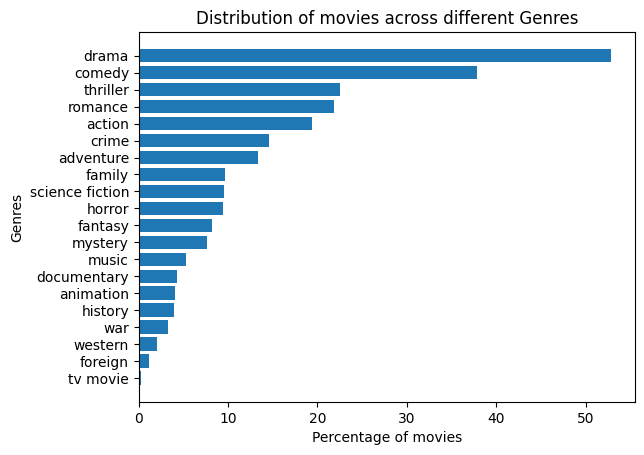

In [30]:
dist = []
den = len(train_movies)
for i in genres:
    v = len(train_movies[train_movies.genres.str.match('.*'+i+'.*')==True])/den*100
    dist.append((v,i))
dist = pd.DataFrame(dist).sort_values(0)

plt.barh(dist[1], dist[0])
plt.title('Distribution of movies across different Genres')
plt.xlabel('Percentage of movies')
plt.ylabel('Genres')
plt.show()

> More movies belong to genres like drama, comedy, thriller, etc than others

In [31]:
# For graph based recommendation, we use these values for giving weightage
# By taking inverse of the proportion of movies belonging to a certain genre, 
# we are giving more importance to less frequent genres and vice versa
dist[0] = dist[0].apply(lambda x: x**(-1))
weights_genre = dict(zip(list(dist[1].values),list(dist[0].values)))
weights_genre

{'tv movie': 3.8568421052631576,
 'foreign': 0.9160000000000001,
 'western': 0.4852980132450331,
 'war': 0.3028099173553719,
 'history': 0.2544444444444444,
 'animation': 0.24756756756756756,
 'documentary': 0.2341214057507987,
 'music': 0.19083333333333335,
 'mystery': 0.13179856115107913,
 'fantasy': 0.12172757475083056,
 'horror': 0.10574314574314575,
 'science fiction': 0.1054388489208633,
 'family': 0.10350282485875706,
 'adventure': 0.07515897435897435,
 'crime': 0.06855004677268477,
 'action': 0.051533052039381154,
 'romance': 0.04585732165206508,
 'thriller': 0.044331518451300664,
 'comedy': 0.02645487364620939,
 'drama': 0.01891584925141972}

## 2.7 Keywords feature analysis

In [32]:
keywords = set()
for i in train_movies.keywords:
    keywords.update(ast.literal_eval(i))
keywords=list(keywords)
print('Total keywords:', len(keywords))
keywords[:10]

Total keywords: 11611


['clumsiness',
 '',
 'exhaustion',
 'archipelago',
 'death row',
 'small town thieves',
 'torture',
 'crime spree',
 'monolog',
 'electroconvulsive therapy']

100%|███████████████████████████████████████████████████████████████████████████| 11611/11611 [01:21<00:00, 142.48it/s]


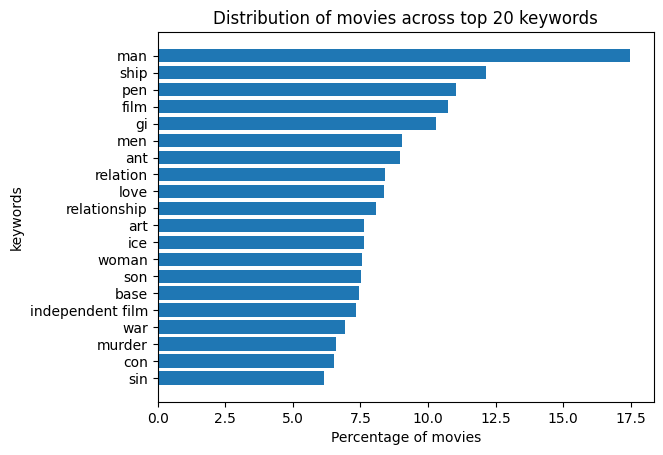

In [33]:
dist = []
den = len(train_movies)
for i in tqdm(keywords):
    if i=='':                                                    #empty keyword
        continue
    v = len(train_movies[train_movies.keywords.str.match('.*'+i+'.*')==True])/den*100
    dist.append((v,i))
dist = pd.DataFrame(dist).sort_values(0)

top = dist[::-1][:20][::-1]
plt.barh(top[1], top[0])
plt.title('Distribution of movies across top 20 keywords')
plt.xlabel('Percentage of movies')
plt.ylabel('keywords')
plt.show()

> some keywords are more popular than others

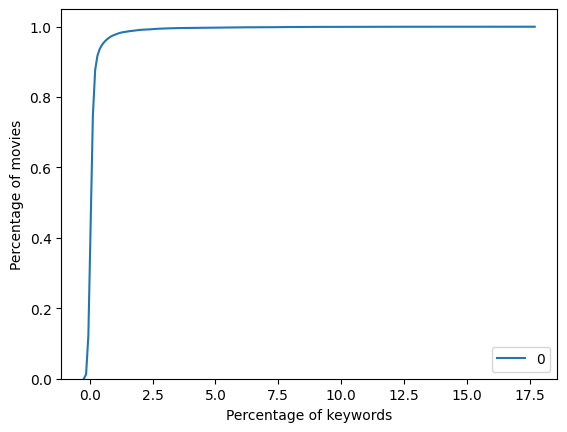

In [34]:
sns.kdeplot(dist, cumulative=True)
#plt.title()
plt.xlabel('Percentage of keywords')
plt.ylabel('Percentage of movies')
plt.show()
#plt.xticks(np.arange(len(dist)),labels=dist[1])

* Less than 0.5% keywords cover more than 90% movies
* It means that most of the keywords are seen very rarely 

In [35]:
# For graph based recommendation, we use these values for giving weightage
# By taking inverse of the proportion of movies belonging to a certain keyword, 
# we are giving more importance to less frequent keywords and vice versa
dist[0] = dist[0].apply(lambda x: (x+1)**(-1))
weights_keywords = dict(zip(list(dist[1].values),list(dist[0].values)))
weights_keywords

{'middle-earth (tolkien)': 1.0,
 'los angeles international airport (lax)': 1.0,
 'columbia broadcasting system (cbs)': 1.0,
 'son (musikstil)': 1.0,
 'tough \xa0girl': 1.0,
 'multiple chemical sensitivity (mcs)': 1.0,
 'national security agency (nsa)': 1.0,
 'lover (female)': 1.0,
 'turning into a vampire': 0.9865374259558428,
 'wood chopping': 0.9865374259558428,
 'feudal japan': 0.9865374259558428,
 'singles bar': 0.9865374259558428,
 'plant food': 0.9865374259558428,
 'killing a dog': 0.9865374259558428,
 'toad': 0.9865374259558428,
 'decorum': 0.9865374259558428,
 'tunesia': 0.9865374259558428,
 'confidence artist': 0.9865374259558428,
 'magic mushroom': 0.9865374259558428,
 'swimmer': 0.9865374259558428,
 'red square': 0.9865374259558428,
 "homer's iliad": 0.9865374259558428,
 'formentera': 0.9865374259558428,
 'jack of spades': 0.9865374259558428,
 'dark horse comics': 0.9865374259558428,
 'wedding chapel': 0.9865374259558428,
 'johnny cash': 0.9865374259558428,
 'leaving home':

## 2.8 EDA: Train Data

### 2.8.1 Distribution of Ratings

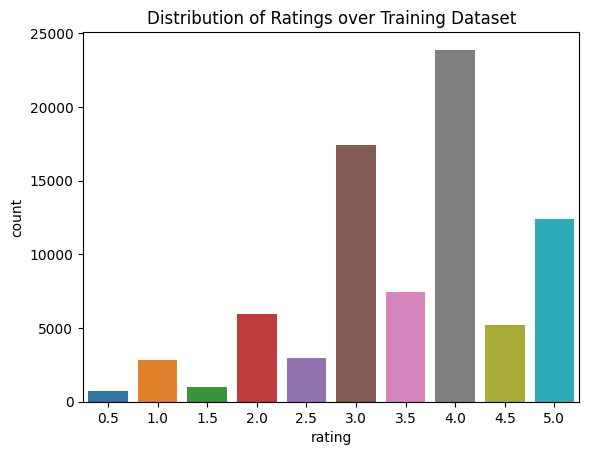

In [28]:
sns.countplot(x=X_train.rating)
plt.title('Distribution of Ratings over Training Dataset')
plt.show()

### 2.8.2 Ratings given by users analysis

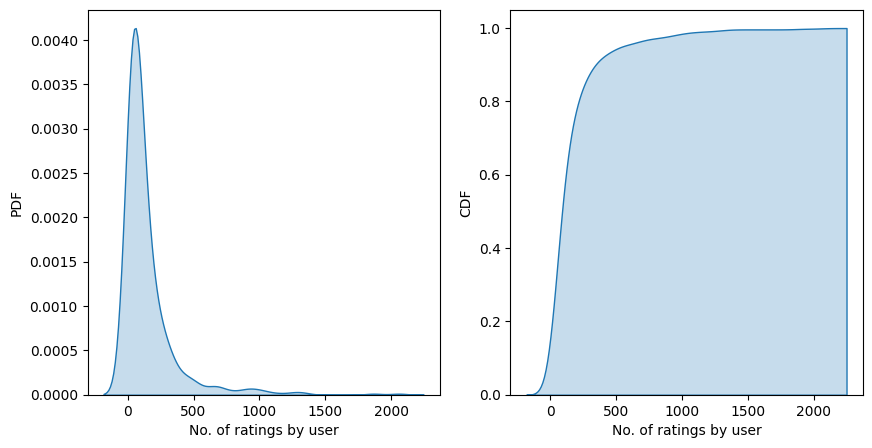

In [28]:
user_rates = X_train.groupby('userId').rating.count()
fig,ax = plt.subplots(1,2, figsize=(10,5)) 
sns.kdeplot(user_rates,ax=ax[0], shade=True)
ax[0].set_xlabel('No. of ratings by user')
ax[0].set_ylabel('PDF')
sns.kdeplot(user_rates,ax=ax[1], cumulative=True, shade=True)
ax[1].set_xlabel('No. of ratings by user')
ax[1].set_ylabel('CDF')
plt.show()

In [29]:
user_rates.describe()

count     546.000000
mean      146.241758
std       222.321860
min         6.000000
25%        34.250000
50%        64.000000
75%       160.750000
max      2058.000000
Name: rating, dtype: float64

* Roughly 85% users have rated about 150 movies on an average
* Maximum no. of ratings by a user is 2058

In [30]:
def percentile(n,df):
    n=n/100
    return df.sort_values().iloc[int(len(df)*n)]

In [31]:
for i in range(90,100):
    print(str(i)+'th percentile value:',percentile(i,user_rates))

90th percentile value: 323
91th percentile value: 340
92th percentile value: 399
93th percentile value: 423
94th percentile value: 485
95th percentile value: 520
96th percentile value: 645
97th percentile value: 726
98th percentile value: 929
99th percentile value: 1141


In [32]:
for i in np.arange(99,100.1,0.1):
    print(str(np.round(i,1))+'th percentile value:',percentile(i,user_rates))

99.0th percentile value: 1141
99.1th percentile value: 1253
99.2th percentile value: 1253
99.3th percentile value: 1290
99.4th percentile value: 1290
99.5th percentile value: 1340
99.6th percentile value: 1340
99.7th percentile value: 1866
99.8th percentile value: 1866
99.9th percentile value: 2058
100.0th percentile value: 2058


### 2.8.3 Ratings given on movies analysis

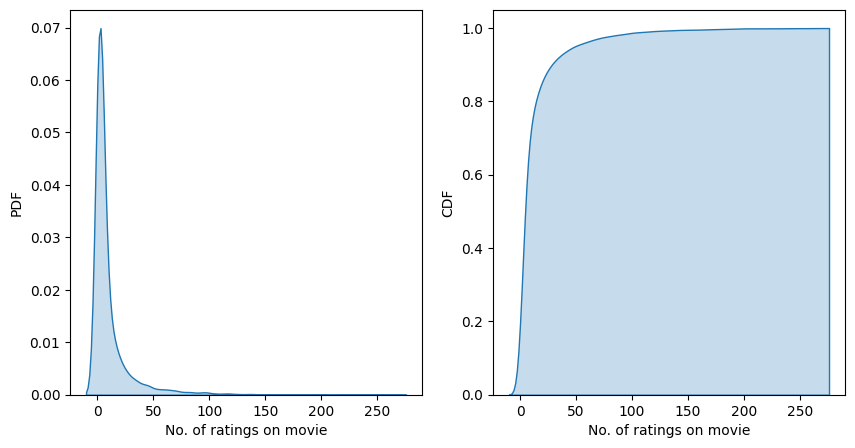

In [33]:
movie_rates = X_train.groupby('movieId').rating.count()
fig,ax = plt.subplots(1,2, figsize=(10,5)) 
sns.kdeplot(movie_rates,ax=ax[0], shade=True)
ax[0].set_xlabel('No. of ratings on movie')
ax[0].set_ylabel('PDF')
sns.kdeplot(movie_rates,ax=ax[1], cumulative=True, shade=True)
ax[1].set_xlabel('No. of ratings on movie')
ax[1].set_ylabel('CDF')
plt.show()

In [34]:
movie_rates.describe()

count    7328.000000
mean       10.896288
std        21.938445
min         1.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       265.000000
Name: rating, dtype: float64

* A movie has around 10 ratings on an average
* Maximum no. of ratings on a movie is 265

In [35]:
for i in range(90,100):
    print(str(i)+'th percentile value:',percentile(i,movie_rates))

90th percentile value: 28
91th percentile value: 31
92th percentile value: 34
93th percentile value: 38
94th percentile value: 43
95th percentile value: 48
96th percentile value: 57
97th percentile value: 68
98th percentile value: 84
99th percentile value: 114


In [36]:
for i in np.arange(99,100.1,0.1):
    print(str(np.round(i,1))+'th percentile value:',percentile(i,movie_rates))

99.0th percentile value: 114
99.1th percentile value: 117
99.2th percentile value: 120
99.3th percentile value: 127
99.4th percentile value: 135
99.5th percentile value: 143
99.6th percentile value: 164
99.7th percentile value: 174
99.8th percentile value: 189
99.9th percentile value: 197
100.0th percentile value: 265


# <font color='green'> 3. Popularity based RS

In [27]:
#movies that are rated by atleast 100 users
top_bool = X_train.groupby('movieId').count()['rating']
top_ind = top_bool[top_bool>100].index

top_movies = X_train[X_train.movieId.isin(top_ind)]
top20_ids = top_movies.groupby('movieId').rating.mean().sort_values(ascending=False)[:20].index        #average rating

In [28]:
print('Top 20 movies on the platform: \n')
for ind in top20_ids:
    print(train_movies[train_movies.movieId==ind].title.values[0])

Top 20 movies on the platform: 

The Godfather
The Shawshank Redemption
The Usual Suspects
Schindler's List
The Godfather: Part II
One Flew Over the Cuckoo's Nest
Fargo
Star Wars
The Empire Strikes Back
The Lord of the Rings: The Fellowship of the Ring
American Beauty
Raiders of the Lost Ark
Monty Python and the Holy Grail
Pulp Fiction
The Princess Bride
The Matrix
GoodFellas
The Lord of the Rings: The Return of the King
The Silence of the Lambs
Good Will Hunting


# <font color='green'> 4. Collaborative Filtering

## 4.1 Trainset and Testset

In [25]:
train_ratings = X_train[['userId','movieId','rating']]
test_ratings = X_test[['userId','movieId','rating']]

In [26]:
#Trainset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(train_ratings,reader)
trainset = data.build_full_trainset()

#Testset
#list of list (or tuples)==> (user, id, rating)
testset = test_ratings.values

## 4.2 Training Models

In [28]:
def get_predictions(results):
    true = np.array([i.r_ui for i in results])
    pred = np.array([i.est for i in results])
    return true,pred

def rmse(true,pred):
    return np.sqrt(np.mean((true-pred)**2))

### 4.2.1 BaselineOnly

In [35]:
bsl_options = {
    "method": "sgd",
    "learning_rate": 0.00005,
}
algo = BaselineOnly(bsl_options=bsl_options)
algo.fit(trainset)

Estimating biases using sgd...


In [36]:
train_test = trainset.build_testset()
train_results = algo.test(train_test)#, verbose=True)
test_results = algo.test(testset)#, verbose=True)

In [37]:
true,pred = get_predictions(train_results)
print('Train RMSE:', rmse(true,pred))
true,pred = get_predictions(test_results)
print('Test RMSE:', rmse(true,pred))

Train RMSE: 1.003646259018717
Test RMSE: 1.0643783580039998


### 4.2.2 SVD

In [61]:
svd_algo = SVD(n_factors=100, biased=True, random_state=42)
svd_algo.fit(trainset)

In [62]:
train_test = trainset.build_testset()
train_results = svd_algo.test(train_test)#, verbose=True)
test_results = svd_algo.test(testset)#, verbose=True)

In [63]:
true,pred = get_predictions(train_results)
print('Train RMSE:', rmse(true,pred))
true,pred = get_predictions(test_results)
print('Test RMSE:', rmse(true,pred))

Train RMSE: 0.6522946861909564
Test RMSE: 1.0194555971818868


### 4.2.3 SVDpp

In [64]:
if not os.path.isfile(path_+'svdpp_algo.pkl'):
    svdpp_algo = SVDpp(random_state=24)
    svdpp_algo.fit(trainset)
    surprise.dump.dump(path_+'svdpp_algo.pkl',algo=svdpp_algo)
    print('Done Dumping...!')
svdpp_algo = surprise.dump.load(path_+'svdpp_algo.pkl')[1]       #tuple (prediction,algo)

Done Dumping...!


In [65]:
train_test = trainset.build_testset()
train_results = svdpp_algo.test(train_test)#, verbose=True)
test_results = svdpp_algo.test(testset)#, verbose=True)

In [66]:
true,pred = get_predictions(train_results)
print('Train RMSE:', rmse(true,pred))
true,pred = get_predictions(test_results)
print('Test RMSE:', rmse(true,pred))

Train RMSE: 0.6973894260142327
Test RMSE: 1.0171675467576995


## 4.3 Summary

In [67]:
x = PrettyTable()
x.field_names = ['Model', 'Train RMSE', 'Test RMSE']
x.add_row(['BaselineOnly', str(np.round(1.003646259018717, 4)), str(np.round(1.0643783580039998, 4))])
x.add_row(['SVD', str(np.round(0.6522946861909564, 4)), str(np.round(1.0194555971818868, 4))])
x.add_row(['SVD++', str(np.round(0.6973894260142327, 4)), str(np.round(1.0171675467576995, 4))])
print(x)

+--------------+------------+-----------+
|    Model     | Train RMSE | Test RMSE |
+--------------+------------+-----------+
| BaselineOnly |   1.0036   |   1.0644  |
|     SVD      |   0.6523   |   1.0195  |
|    SVD++     |   0.6974   |   1.0172  |
+--------------+------------+-----------+


## 4.4 Recommed movies

In [35]:
def recommend_10(user_id, svd_algo):
    movies_watched = set(train_ratings[train_ratings.userId==user_id].movieId.values)
    
    if len(movies_watched)==0:
        return 'User new to the platform'
    
    movies_unwatched = set(train_movies.movieId) - movies_watched

    results = []
    for mid in movies_unwatched:
        results.append(svd_algo.predict(user_id, mid))
    
    df =  pd.DataFrame([(i.iid,i.est) for i in results], columns=['movieId', 'rating']).sort_values('rating', ascending=False)
    top10_ids = df.movieId[:10] 
    
    return train_movies[train_movies.movieId.isin(top10_ids)][['title','genres']]#, top10_ids


In [36]:
recommend_10(1,algo)

,title,genres
273,Three Colors: Red,"['drama', 'mystery', 'romance']"
320,Forrest Gump,"['comedy', 'drama', 'romance']"
618,A Close Shave,"['family', 'animation', 'comedy']"
779,Night of the Living Dead,['horror']
780,The African Queen,"['adventure', 'war', 'romance']"
946,The Princess Bride,"['adventure', 'family', 'fantasy', 'comedy', '..."
1514,Rain Man,['drama']
2361,Fight Club,['drama']
3337,Memento,"['mystery', 'thriller']"
6257,The Departed,"['drama', 'thriller', 'crime']"


# <font color='green'> 5. Graph based Recommendations

## 5.1 Creating nodes and edges

In [36]:
edges = []
for row in train_movies.iterrows():
    mid = row[1].movieId
    edges.extend([(mid, k, weights_keywords.get(k,0)*10) for k in ast.literal_eval(row[1].keywords)]) 
    edges.extend([(mid, g, weights_genre[g]*200) for g in ast.literal_eval(row[1].genres)])
edges[:10]

#we give 20 times more weightage to the genres of the movie

[(1, 'jealousy', 4.354647016876634),
 (1, 'toy', 7.532894736842105),
 (1, 'boy', 3.4039390561129688),
 (1, 'friendship', 2.7213309566250743),
 (1, 'friends', 2.05680925115078),
 (1, 'rivalry', 6.14352783366868),
 (1, 'boy next door', 9.734325185972368),
 (1, 'new toy', 9.734325185972368),
 (1, 'toy comes to life', 8.799231508165226),
 (1, 'animation', 49.513513513513516)]

In [37]:
data = pd.DataFrame(edges, columns=['movieId','keywords','weights'])
print(data.shape)
data.head()

(71101, 3)


,movieId,keywords,weights
0,1,jealousy,4.354647
1,1,toy,7.532895
2,1,boy,3.403939
3,1,friendship,2.721331
4,1,friends,2.056809


## 5.2 Creating Graph

In [41]:
if not os.path.isfile(path_+'graph.pkl'):
    B = nx.Graph()
    B.add_nodes_from(data.movieId.unique(), bipartite=0, label='movie')
    B.add_nodes_from(data.keywords.unique(), bipartite=1, label='keygen')
    B.add_weighted_edges_from(edges)
    pickle.dump(B,open(path_+'graph.pkl','wb'))

B = pickle.load(open(path_+'graph.pkl','rb'))

In [42]:
print('No.of nodes :', len(B.nodes()))         #7311movies + 11612(keywords+genres)
print('No. of edges:', len(B.edges()))

No.of nodes : 18923
No. of edges: 70868


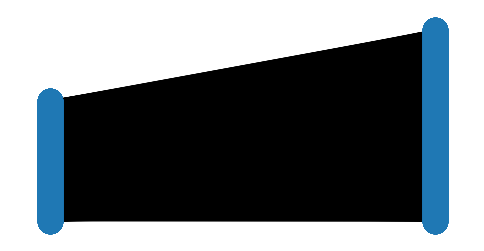

In [43]:
l,r = bipartite.sets(B)
pos = {}                                                #key=node, value=pos=(x,y)
pos.update((node,(1,ind)) for ind,node in enumerate(l))
pos.update((node,(2,ind)) for ind,node in enumerate(r))

fig,ax = plt.subplots(figsize=(6,3))
nx.draw(B, pos=pos, ax=ax)#, with_labels=True)
plt.show()

### Example of a node and its edges based on edge weight

* genres are weighted according to the inverse of their distribution, thus giving more weight to the less popular genres
* keywords too are weighted according to the same logic
* 20 times more weightage to the genres of the movie

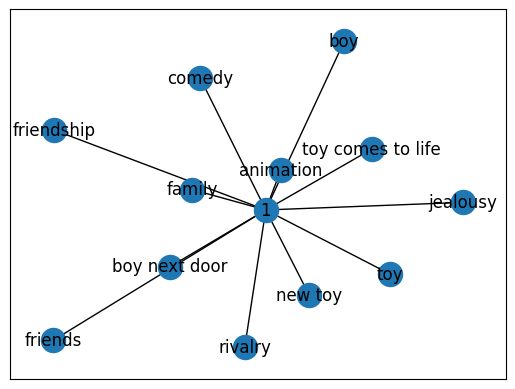

In [46]:
sub=nx.ego_graph(B,1)          #Movie is 'The Toy Story'... genres=[comedy,family,animation]
nx.draw_networkx(sub)

In [47]:
nx.get_edge_attributes(sub, 'weight')

{(1, 'jealousy'): 4.354647016876634,
 (1, 'toy'): 7.532894736842105,
 (1, 'boy'): 3.4039390561129688,
 (1, 'friendship'): 2.7213309566250743,
 (1, 'friends'): 2.05680925115078,
 (1, 'rivalry'): 6.14352783366868,
 (1, 'boy next door'): 9.734325185972368,
 (1, 'new toy'): 9.734325185972368,
 (1, 'toy comes to life'): 8.799231508165226,
 (1, 'animation'): 49.513513513513516,
 (1, 'comedy'): 5.290974729241878,
 (1, 'family'): 20.70056497175141}

## 5.3 Recommending movies

In [64]:
def graph_recommend(q):
    
    rw = BiasedRandomWalk(StellarGraph(B))                       
    walk = rw.run(nodes=[q], n=1, length=10000, p=0.01, q=100, weighted=True, seed=42)

    #with 1/p prob, it returns to the source node
    #with 1/q prob, it moves away from the source node    
    #Shape of walk: (1,10000)

    walk = list(filter(lambda x:type(x)==int, walk[0])) #getting rid of keywords and genres... left with only movieIds
    walk = list(map(str, walk))                         #for countvectorizer
    walk = ' '.join(walk)                               #['m1','m2','m3'] ====> 'm1 m2 m3'... for tokenzation 
    
    vocab = {str(mov):ind for ind,mov in enumerate(train_movies.movieId.sort_values().unique())}   #movieId:index
    vec = CountVectorizer(vocabulary=vocab)
    embed = vec.fit_transform([walk])
    
    reverse_vocab = {v:int(k) for k,v in vocab.items()}         #index:movieId

    embed = np.array(embed.todense())[0]

    top5_ids=[]
    for ind in embed.argsort()[::-1]:
        if len(top5_ids)==5: break
        movid = reverse_vocab[ind]
        if movid!=q:
            top5_ids.append(movid)
    
    print("Movies similar to '{}':".format(train_movies[train_movies.movieId==q].title.values[0]))
    return train_movies[train_movies.movieId.isin(top5_ids)]

In [65]:
q=2571                               #The Matrix(2571)    #Toy Story(1)    #Spider-Man(5349)
graph_recommend(q)

Movies similar to 'The Matrix':


,title,genres,movieId,tmdbId,keywords
1186,Smilla's Sense of Snow,"['action', 'crime', 'drama', 'mystery', 'thril...",1480,9311.0,"['copenhagen', 'inuit', 'comet', 'arctic', 'sn..."
2982,Asylum,"['horror', 'thriller', 'mystery']",3757,25993.0,"['asylum', 'insane asylum', 'anthology', 'psyc..."
3215,Breakheart Pass,"['thriller', 'western', 'mystery']",4045,8043.0,"['prisoner', 'train ride', 'governor', 'army',..."
3666,The Deep End,"['drama', 'crime', 'mystery']",4723,24936.0,"['casino', 'ambulance', 'fight', 'wound', 'fri..."
3741,Mulholland Drive,"['thriller', 'drama', 'mystery']",4848,1018.0,"['schizophrenia', 'identity', 'amnesia', 'loss..."
